# Clinical Symptom Analysis - ECT

Do spectral features relate to clinical symptom changes after ECT treatment? In this notebook, we use an existing dataset shared with us by Hill, et al 2020 of pre- and post-treatment resting state EEG data from 23 patients receiving a standard therapeutic course of ECT as a treatment for Major Depressive Disorder. 

Using spectral parameterization, we quantified aperiodic exponent, offest, as well as features of oscillatory peaks (when present) in the delta (1-4 Hz), theta (4-7 Hz), and alpha (7-14 Hz) frequency ranges. Here, we attempt to relate these features to standard measures of clinical symptom severity, the Hamilton Depression Rating Scale (HAMD/HDRS) and the Montgomery-Asberg Depression Rating Scale (MADRS). Specifically, we focus on how spectral features like aperiodic activity and offset might better capture changes in depressive symptom improvement as an effect of ECT. This analysis expands on initial research by Smith et al, 2022. 

In [1]:
import numpy as np
import scipy.io as sio
import pandas as pd
import h5py as h5

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from pingouin import corr, ttest

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
ECT_clinical = pd.read_csv('../saved_files/ect_files/ect_clinical_data/ECT_clinical.csv')
ECT_HAMD = pd.read_csv('../saved_files/ect_files/ect_clinical_data/ECT_HAMD.csv')
ECT_MOCA = pd.read_csv('../saved_files/ect_files/ect_clinical_data/ECT_MOCA.csv')
ECT_MADRS = pd.read_csv('../saved_files/ect_files/ect_clinical_data/ECT_MADRS.csv')
exp_df = pd.read_csv('../saved_files_appeal/ect_files/ect_all_features.csv', index_col=0)

# 0. Check all clinical ratings for consistency/validity

Data cleaning

In [3]:
ECT_HAMD.head()

,subject,filt,LOCF_responders2,LOCF_remitters3,LOCF_remitters4,LOCF_DROPOUTS,DROPOUTS,DataStatus,ratio2,diff2,...,Anxiety_Psychological_Post,Anxiety_Somatic_Post,LossOfAppetitePost,AnergiaPost,LossOfLibidoPost,HypochondriasisPost,LossOfInsightPost,WeightLossPost,TotalPost,LOCF_TotalPost
0,1,1,1,1,1,0,0,'Completed',0.416667,14.0,...,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,10.0
1,2,1,1,0,0,0,0,'Completed',0.500000,14.0,...,1.0,2.0,2.0,0.0,2.0,0.0,0.0,2.0,14.0,14.0
2,3,1,1,1,1,0,0,'Completed',0.212121,26.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0
3,4,1,1,0,0,0,0,'Completed',0.541667,11.0,...,1.0,0.0,1.0,2.0,2.0,0.0,0.0,0.0,13.0,13.0
4,7,1,0,0,0,0,0,'Baseline Only',NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
ECT_clinical[['subject', 'x_OfTxsReceived']]

,subject,x_OfTxsReceived
0,1,16.0
1,2,11.0
2,3,8.0
3,4,10.0
4,10,11.0
5,13,15.0
6,16,14.0
7,18,17.0
8,19,11.0
9,21,10.0


In [5]:
ECT_MADRS.head()

,subject,diff_MADRS,ratioMADRS,Apparent SandessPre,ReportedSadnesspre,InnerTensionPre,ReducedSleepPre,ReducedAppetitePre,ConcentrationDifficultiesPre,LassitudePre,...,ReportedSadnessPost,InnerTensionPost,ReducedSleepPost,ReducedAppetitePost,ConcentrationDifficultiesPost,LassitudePost,InabilitytoFeelPost,PessimisticThoughtsPost,SuicidalThoughtsPost,TotalPost
0,2,16.0,0.466667,4.0,3.0,2.0,3.0,3.0,4.0,3.0,...,0.0,1.0,2.0,5.0,2.0,1.0,1.0,1.0,0.0,14.0
1,3,34.0,0.190476,5.0,5.0,3.0,2.0,5.0,4.0,5.0,...,0.0,2.0,2.0,0.0,2.0,1.0,1.0,0.0,0.0,8.0
2,4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10,6.0,0.806452,4.0,4.0,3.0,4.0,0.0,4.0,5.0,...,3.0,0.0,3.0,0.0,4.0,4.0,2.0,3.0,2.0,25.0


In [6]:
# rename columns

ECT_HAMD = ECT_HAMD[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                 'TotalPre': 'HAMD_TotalPre',
                                                                                 'TotalPost': 'HAMD_TotalPost'})
ECT_MADRS = ECT_MADRS[['subject', 'TotalPre', 'TotalPost']].copy().rename(columns={'subject': 'patient',
                                                                                   'TotalPre': 'MADRS_TotalPre',
                                                                                   'TotalPost': 'MADRS_TotalPost'})
ECT_clinical = ECT_clinical[['subject', 'x_OfTxsReceived']].copy().rename(columns={'subject': 'patient',
                                                                                   'x_OfTxsReceived': 'n_TxsReceived'})

# merge into single dataframe
all_clinical = pd.merge(ECT_HAMD, ECT_MADRS, on='patient', how='outer')
all_clinical = pd.merge(all_clinical, ECT_clinical, on='patient', how='outer')

In [7]:
all_clinical

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived
0,1,24.0,10.0,NaN,NaN,16.0
1,2,28.0,14.0,30.0,14.0,11.0
2,3,33.0,7.0,42.0,8.0,8.0
3,4,24.0,13.0,NaN,NaN,10.0
4,7,NaN,NaN,NaN,NaN,NaN
5,10,21.0,20.0,31.0,25.0,11.0
6,12,NaN,NaN,NaN,NaN,NaN
7,13,25.0,22.0,32.0,NaN,15.0
8,16,24.0,NaN,35.0,NaN,14.0
9,18,23.0,30.0,32.0,35.0,17.0


### 0.1 calculating Symptom differences and improvement ratios

*Difference = pre - post*  
Difference captures absolute change in depression severity.


*Ratio = (pre - post) / pre*   
Ratio captures relative change in depression severity compared to baseline.

In [8]:
all_clinical['HAMD_diff'] = all_clinical['HAMD_TotalPre'] - all_clinical['HAMD_TotalPost']
all_clinical['HAMD_ratio'] = (all_clinical['HAMD_TotalPre'] - all_clinical['HAMD_TotalPost'])/all_clinical['HAMD_TotalPre']
all_clinical['MADRS_diff'] = all_clinical['MADRS_TotalPre'] - all_clinical['MADRS_TotalPost']
all_clinical['MADRS_ratio'] = (all_clinical['MADRS_TotalPre'] - all_clinical['MADRS_TotalPost'])/all_clinical['MADRS_TotalPre']


In [9]:
all_clinical

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio
0,1,24.0,10.0,NaN,NaN,16.0,14.0,0.583333,NaN,NaN
1,2,28.0,14.0,30.0,14.0,11.0,14.0,0.500000,16.0,0.533333
2,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524
3,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,NaN
8,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,NaN
9,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750


What is the relationship between the two rating scales? Are they correlated? Outliers might indicate incorrectly input data (see patient 13). 

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='HAMD_ratio', ylabel='MADRS_ratio'>

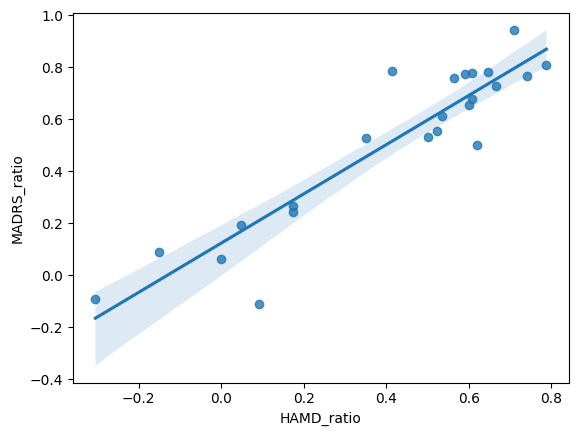

In [10]:
sns.regplot(all_clinical['HAMD_ratio'], all_clinical['MADRS_ratio'])

<AxesSubplot:>

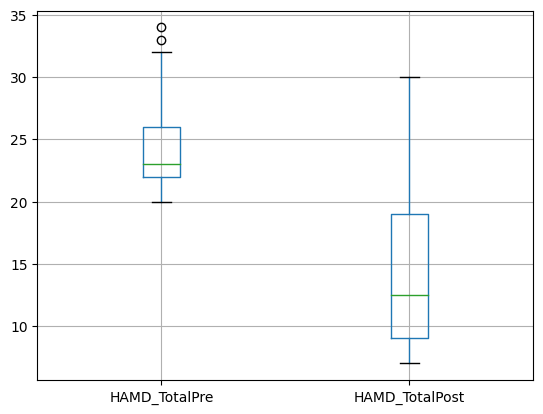

In [11]:
# boxplot for HAMD improvement scores

all_clinical.boxplot(['HAMD_TotalPre', 'HAMD_TotalPost'])

In [12]:
ttest(all_clinical['HAMD_TotalPre'], all_clinical['HAMD_TotalPost'], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,6.717531,25,two-sided,4.860189e-07,"[7.17, 13.52]",1.999309,3.473e+04,1.0


## 1. Frontal only. We're not doing all electrodes anymore ever

What is the relationship between the changes in EEG features pre/post treatment and clinical symptom improvement? What can the average features across all 60 EEG electrodes tell us about clinical symptom changes?

In [13]:
# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# exclude bad fits
exp_df_included = exp_df[exp_df['exclude']==False]

# make delta_amp, theta_amp, and alpha_amp 0 from NaN (so we can do stats on this data, otherwise too many NaNs)
# exp_df_included['delta_amp'].fillna(0, inplace=True)
# exp_df_included['theta_amp'].fillna(0, inplace=True)
# exp_df_included['alpha_amp'].fillna(0, inplace=True)
# exp_df_included

In [14]:
FRONTAL_ONLY = True
# frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
#                     'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
#                     'FC4', 'FC6', 'FT8', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6']

frontal_channels = ['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ',
                    'F2', 'F4', 'F6', 'F8', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2',
                    'FC4', 'FC6']

if FRONTAL_ONLY:
    exp_df_included = pd.DataFrame(exp_df_included[exp_df_included['channel'].isin(frontal_channels)])

In [15]:
# average across ALL electrodes
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

# Pre/Post Difference dataframe
eeg_diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')
eeg_diff_df_mean['patient'] = exp_df_mean['patient']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_7041/417097553.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = exp_df_mean.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all')


In [16]:
eeg_diff_df_mean.head()

,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,patient
1,NaN,NaN,NaN,-1.108569,0.483336,-0.832910,-0.441578,-1.095377,-0.160093,-0.626867,0.184062,-0.309768,-1.310927,-1.024118,3
3,-0.457869,0.000000,0.114182,0.379374,NaN,NaN,NaN,0.159670,0.919282,0.242885,0.463842,0.755472,0.251881,-0.198727,4
5,NaN,NaN,NaN,-0.662014,1.306258,0.172313,-0.833870,-1.154597,1.786946,-1.513896,-0.190827,-0.709270,-0.575327,-0.319810,10
7,0.294653,-0.189057,-0.017966,-0.137365,NaN,NaN,NaN,-0.230923,-0.054072,-0.100419,-0.004685,-0.127788,-0.137568,-0.059526,13
9,NaN,NaN,NaN,-0.826598,0.998726,-1.302610,-0.610565,-1.151354,1.801602,-1.765519,0.155187,-0.209106,-0.701807,-0.485470,16


In [17]:
all_clinical

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio
0,1,24.0,10.0,NaN,NaN,16.0,14.0,0.583333,NaN,NaN
1,2,28.0,14.0,30.0,14.0,11.0,14.0,0.500000,16.0,0.533333
2,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524
3,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,NaN
8,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,NaN
9,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750


In [18]:
clin_eeg_diff_df = pd.merge(all_clinical, eeg_diff_df_mean, on='patient', how='outer')
clin_eeg_diff_df.drop([7,8]) # remove patients with incorrectly input MADRS data

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,1,24.0,10.0,NaN,NaN,16.0,14.0,0.583333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,28.0,14.0,30.0,14.0,11.0,14.0,0.500000,16.0,0.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,0.483336,-0.832910,-0.441578,-1.095377,-0.160093,-0.626867,0.184062,-0.309768,-1.310927,-1.024118
3,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,NaN,NaN,NaN,0.159670,0.919282,0.242885,0.463842,0.755472,0.251881,-0.198727
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548,...,1.306258,0.172313,-0.833870,-1.154597,1.786946,-1.513896,-0.190827,-0.709270,-0.575327,-0.319810
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750,...,NaN,NaN,NaN,-0.860688,1.200003,-1.972226,-0.424327,-0.624648,-0.581223,-0.463106
10,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,0.780488,...,NaN,NaN,NaN,-0.726546,1.261530,-0.263117,1.143182,0.109786,-0.600280,-0.002427
11,21,20.0,23.0,34.0,31.0,10.0,-3.0,-0.150000,3.0,0.088235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### What is the relationship of the HAMD ratio to spectral features and traditional band power measures?

In [24]:
formula = 'HAMD_ratio ~ exponent + offset + delta_amp + delta_bp + theta_bp'

model = ols(formula, clin_eeg_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                 -0.034
Method:                 Least Squares   F-statistic:                    0.8830
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.519
Time:                        12:51:44   Log-Likelihood:               -0.64866
No. Observations:                  19   AIC:                             13.30
Df Residuals:                      13   BIC:                             18.96
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4721      0.165      2.861      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

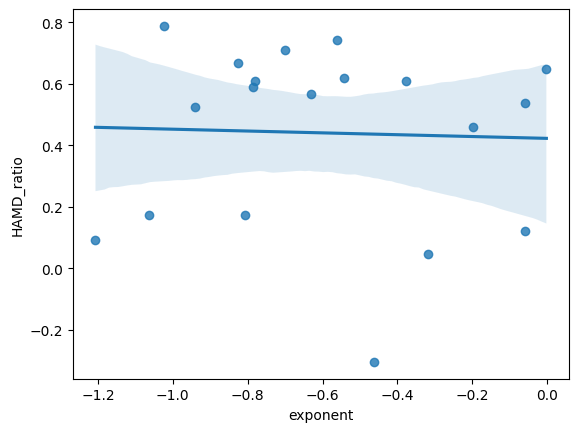

In [25]:
sns.regplot(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['HAMD_ratio'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_diff'>

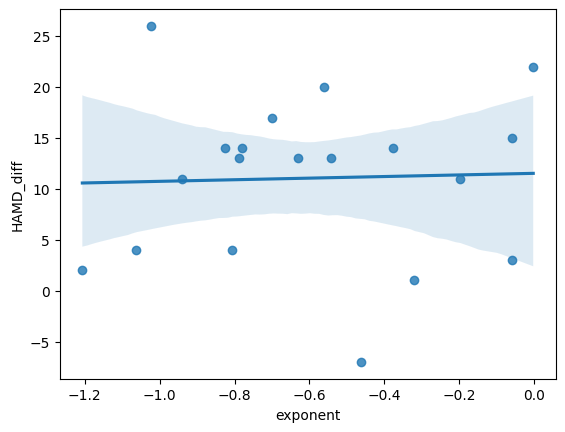

In [26]:
sns.regplot(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['HAMD_diff'])

### What is the relationship of the MADRS ratio to spectral features and traditional band power measures?


In [27]:
formula = 'MADRS_ratio ~ exponent + offset + delta_bp + theta_bp'

model = ols(formula, clin_eeg_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MADRS_ratio   R-squared:                       0.390
Model:                            OLS   Adj. R-squared:                  0.187
Method:                 Least Squares   F-statistic:                     1.920
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.172
Time:                        12:51:47   Log-Likelihood:               -0.20917
No. Observations:                  17   AIC:                             10.42
Df Residuals:                      12   BIC:                             14.58
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5069      0.204      2.490      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [28]:
formula = 'MADRS_diff ~ exponent + offset + delta_bp + theta_bp'

model = ols(formula, clin_eeg_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             MADRS_diff   R-squared:                       0.446
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     2.415
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.106
Time:                        12:51:48   Log-Likelihood:                -60.529
No. Observations:                  17   AIC:                             131.1
Df Residuals:                      12   BIC:                             135.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     16.0670      7.074      2.271      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='MADRS_diff'>

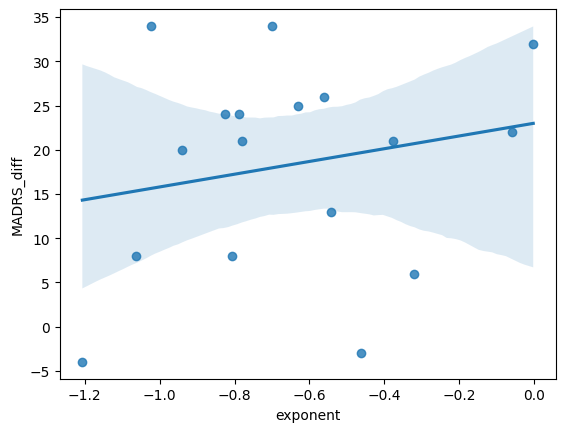

In [29]:
sns.regplot(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['MADRS_diff'])

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='MADRS_ratio'>

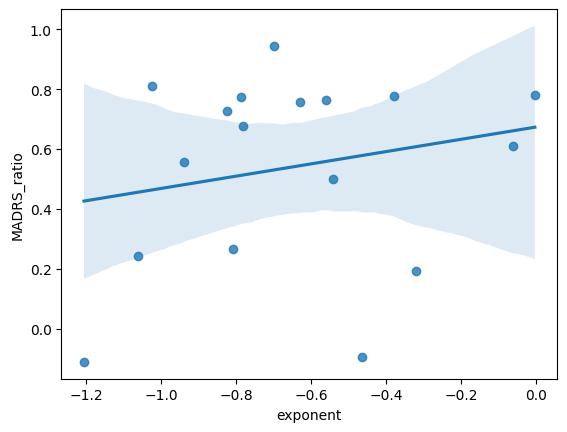

In [30]:
sns.regplot(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['MADRS_ratio'])

In [31]:
corr(clin_eeg_diff_df['exponent'], clin_eeg_diff_df['MADRS_ratio'], method='pearson')

,n,r,CI95%,p-val,BF10,power
pearson,17,0.212769,"[-0.3, 0.63]",0.412274,0.409,0.13096


In [32]:
# correlation heat map visualization
def CorrMtx(df, dropDuplicates = True):
    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)
    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1, center=0)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax, vmin=-1, vmax=1, center=0)

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_5963/2681139096.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


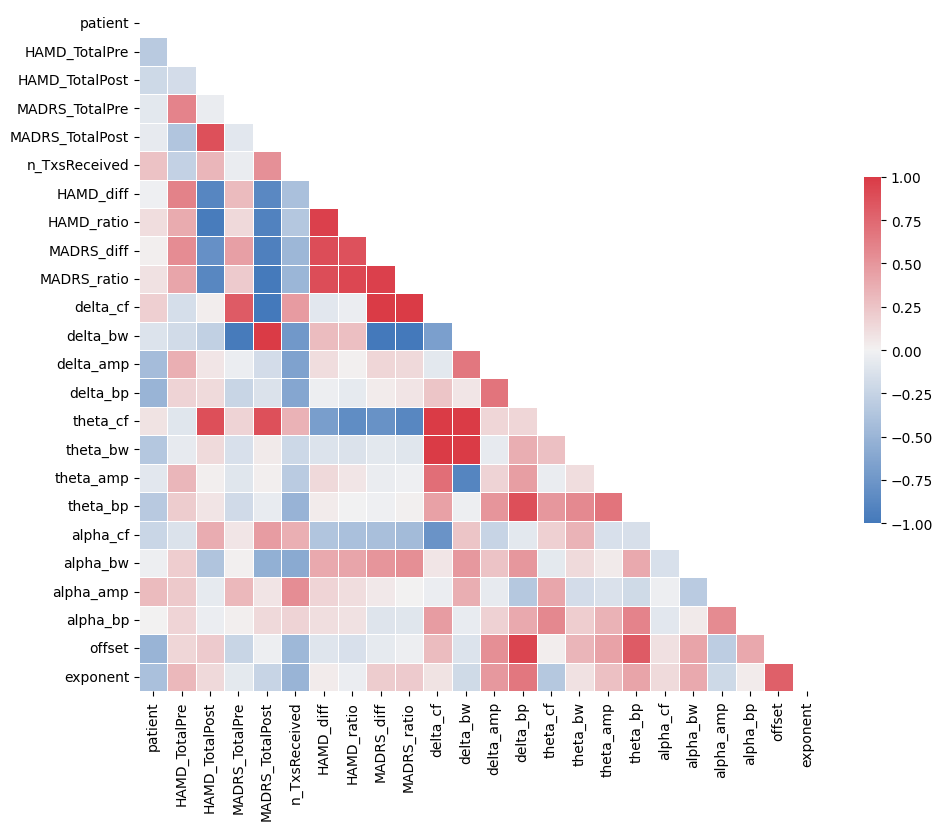

In [33]:
# Diff Ratings correlations
df_corr = clin_eeg_diff_df.corr()

CorrMtx(df_corr, dropDuplicates=True)

### Do responders show different EEG features than non-responders?

In clinical studies (incl. Hill et al, 2020) patients are typically split into two groups, responders (<=50% decrease in symptom severity) and non-responders. Are there differential effects in their EEGs?

In [34]:
responders_diff_df = clin_eeg_diff_df[clin_eeg_diff_df['HAMD_ratio']>= 0.5]
nonresponders_diff_df = clin_eeg_diff_df[clin_eeg_diff_df['HAMD_ratio']<= 0.5]

In [35]:
formula = 'HAMD_ratio ~ exponent + offset + delta_bp + theta_bp'

model = ols(formula, responders_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.271
Model:                            OLS   Adj. R-squared:                 -0.145
Method:                 Least Squares   F-statistic:                    0.6510
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.644
Time:                        12:51:58   Log-Likelihood:                 15.589
No. Observations:                  12   AIC:                            -21.18
Df Residuals:                       7   BIC:                            -18.75
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.5846      0.072      8.121      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [36]:
formula = 'HAMD_ratio ~ exponent + offset + delta_bp + theta_bp'

model = ols(formula, nonresponders_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                 -0.373
Method:                 Least Squares   F-statistic:                    0.5928
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.706
Time:                        12:51:59   Log-Likelihood:                 3.7646
No. Observations:                   7   AIC:                             2.471
Df Residuals:                       2   BIC:                             2.200
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3524      0.309      1.141      0.3

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 7 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


# 3. Does Pre-Treatment EEG predict response to treatment?

In [19]:
# features to include in analysis
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']

# average across ALL electrodes
exp_df_mean = pd.DataFrame(exp_df_included.groupby(['patient', 'pre_post'], as_index=False)[features].mean())

# Pre ONLY dataframe
eeg_pre_df_mean = pd.DataFrame(exp_df_mean[exp_df_mean['pre_post']=='pre'])

In [20]:
eeg_pre_df_mean.head()

,patient,pre_post,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
1,3,pre,NaN,NaN,NaN,-12.133939,6.799188,1.300002,0.275062,-12.194664,9.615628,1.449038,0.694311,-11.900750,-12.032917,0.339566
3,4,pre,2.387229,1.000000,0.210006,-11.730984,NaN,NaN,NaN,-12.198185,9.858490,1.511450,1.458963,-11.327265,-11.515600,0.820470
5,10,pre,NaN,NaN,NaN,-12.000635,6.123304,2.108303,0.289414,-12.134196,10.397197,1.306758,1.215247,-11.866269,-11.686848,0.931087
7,13,pre,1.936185,1.093397,0.116007,-11.883743,NaN,NaN,NaN,-12.241934,7.607819,1.033290,1.402025,-11.686568,-11.615048,1.026275
9,16,pre,NaN,NaN,NaN,-11.935276,5.978162,1.163335,0.320467,-12.165789,10.356948,2.252768,0.905743,-11.690054,-11.596002,0.833458


In [21]:
clin_eeg_pre_df = pd.merge(all_clinical, eeg_pre_df_mean, on='patient', how='outer')
clin_eeg_pre_df.drop([7,8])

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,1,24.0,10.0,NaN,NaN,16.0,14.0,0.583333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,28.0,14.0,30.0,14.0,11.0,14.0,0.500000,16.0,0.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,6.799188,1.300002,0.275062,-12.194664,9.615628,1.449038,0.694311,-11.900750,-12.032917,0.339566
3,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,NaN,NaN,NaN,-12.198185,9.858490,1.511450,1.458963,-11.327265,-11.515600,0.820470
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548,...,6.123304,2.108303,0.289414,-12.134196,10.397197,1.306758,1.215247,-11.866269,-11.686848,0.931087
6,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750,...,NaN,NaN,NaN,-12.377378,8.777053,1.372158,0.351864,-12.309103,-11.716429,0.834459
10,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,0.780488,...,NaN,NaN,NaN,-13.110498,10.968259,1.204090,1.803531,-12.124270,-12.398633,0.720200
11,21,20.0,23.0,34.0,31.0,10.0,-3.0,-0.150000,3.0,0.088235,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='HAMD_ratio'>

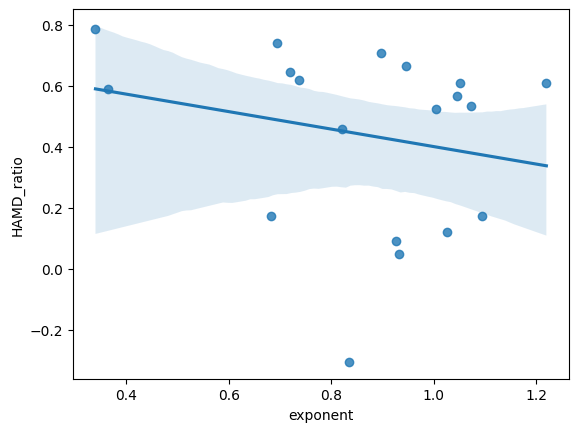

In [22]:
sns.regplot(clin_eeg_pre_df['exponent'], clin_eeg_pre_df['HAMD_ratio'])

In [23]:
formula = 'HAMD_ratio ~ exponent + offset + delta_bp + theta_bp + theta_amp'

model = ols(formula, clin_eeg_pre_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                 -0.477
Method:                 Least Squares   F-statistic:                    0.2894
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.903
Time:                        16:20:26   Log-Likelihood:                 1.0755
No. Observations:                  12   AIC:                             9.849
Df Residuals:                       6   BIC:                             12.76
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1039      4.037     -0.521      0.6

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [24]:
formula = 'MADRS_ratio ~ exponent + offset + delta_bp + theta_bp + theta_amp'

model = ols(formula, clin_eeg_pre_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MADRS_ratio   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                 -0.470
Method:                 Least Squares   F-statistic:                    0.2967
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.898
Time:                        16:20:28   Log-Likelihood:               -0.98607
No. Observations:                  12   AIC:                             13.97
Df Residuals:                       6   BIC:                             16.88
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7207      4.793     -0.776      0.4

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='exponent', ylabel='MADRS_ratio'>

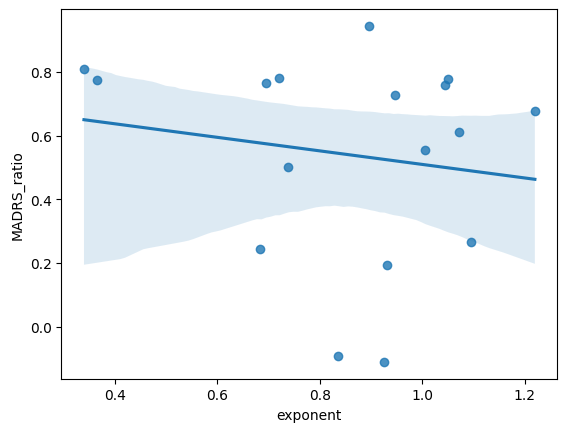

In [25]:
sns.regplot(clin_eeg_pre_df['exponent'], clin_eeg_pre_df['MADRS_ratio'])

### Does pre-treatment exponent predict change in exponent?

This was the case in Smith et al, 2022.

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'pre-ECT exponent')

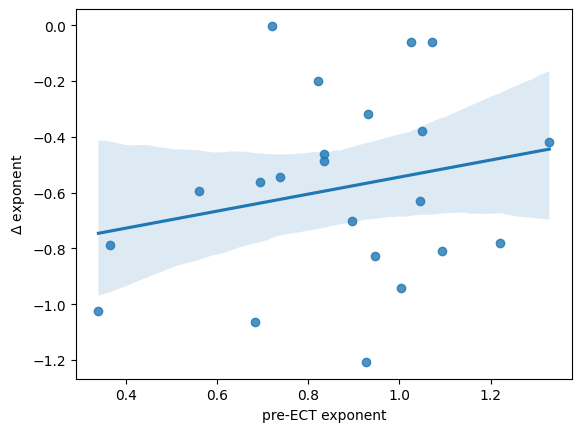

In [26]:
sns.regplot(clin_eeg_pre_df['exponent'], clin_eeg_diff_df['exponent'])
plt.ylabel('$\Delta$ exponent')
plt.xlabel('pre-ECT exponent')

# 4. How does exponent (baseline & change) affect response to treatment?

Does combining the baseline exponent measurement with the patients change in exponent through treatment provide a stronger prediction about treatment response and therapeutic efficacy? This was the case in Smith et al, 2022.

In [27]:
clin_eeg_pre_df.head()

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,1,24.0,10.0,NaN,NaN,16.0,14.0,0.583333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,28.0,14.0,30.0,14.0,11.0,14.0,0.500000,16.0,0.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,6.799188,1.300002,0.275062,-12.194664,9.615628,1.449038,0.694311,-11.900750,-12.032917,0.339566
3,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,NaN,NaN,NaN,-12.198185,9.858490,1.511450,1.458963,-11.327265,-11.515600,0.820470
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
clin_eeg_diff_df.head()

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent
0,1,24.0,10.0,NaN,NaN,16.0,14.0,0.583333,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,28.0,14.0,30.0,14.0,11.0,14.0,0.500000,16.0,0.533333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,0.483336,-0.83291,-0.441578,-1.095377,-0.160093,-0.626867,0.184062,-0.309768,-1.310927,-1.024118
3,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,NaN,NaN,NaN,0.159670,0.919282,0.242885,0.463842,0.755472,0.251881,-0.198727
4,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [29]:
# data cleaning and DF combining 

features = ['patient', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp', 'theta_cf', 'theta_bw', 'theta_amp',
            'theta_bp', 'alpha_cf', 'alpha_bw', 'alpha_amp', 'alpha_bp', 'offset', 'exponent']



eeg_diff_df = clin_eeg_diff_df[features].copy().rename(columns={'delta_cf': 'd_delta_cf',
                                                             'delta_bw': 'd_delta_bw', 
                                                             'delta_amp': 'd_delta_amp',
                                                             'delta_bp': 'd_delta_bp',
                                                             'theta_cf': 'd_theta_cf',
                                                             'theta_bw': 'd_theta_bw',
                                                             'theta_amp': 'd_theta_amp',
                                                             'theta_bp': 'd_theta_bp',
                                                             'alpha_cf': 'd_alpha_cf',
                                                             'alpha_bw': 'd_alpha_bw',
                                                             'alpha_amp': 'd_alpha_amp',
                                                             'alpha_bp': 'd_alpha_bp',
                                                             'offset': 'd_offset',
                                                             'exponent': 'd_exponent'})

clin_pre_diff_df = pd.merge(eeg_diff_df, clin_eeg_pre_df, on='patient', how='outer')

In [30]:
formula = 'MADRS_ratio ~ exponent + d_exponent'

model = ols(formula, clin_pre_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            MADRS_ratio   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                 -0.044
Method:                 Least Squares   F-statistic:                    0.6597
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.532
Time:                        16:20:38   Log-Likelihood:                -3.6484
No. Observations:                  17   AIC:                             13.30
Df Residuals:                      14   BIC:                             15.80
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9308      0.371      2.506      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [31]:
formula = 'MADRS_diff ~ exponent + d_exponent'

model = ols(formula, clin_pre_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             MADRS_diff   R-squared:                       0.123
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.9790
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.400
Time:                        16:20:38   Log-Likelihood:                -64.435
No. Observations:                  17   AIC:                             134.9
Df Residuals:                      14   BIC:                             137.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     36.1643     13.265      2.726      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [32]:
formula = 'HAMD_ratio ~ exponent + d_exponent'

model = ols(formula, clin_pre_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             HAMD_ratio   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.068
Method:                 Least Squares   F-statistic:                    0.4243
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.661
Time:                        16:20:39   Log-Likelihood:                -2.9353
No. Observations:                  19   AIC:                             11.87
Df Residuals:                      16   BIC:                             14.70
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6958      0.332      2.097      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [33]:
formula = 'HAMD_diff ~ exponent + d_exponent'

model = ols(formula, clin_pre_diff_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              HAMD_diff   R-squared:                       0.122
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.108
Date:                Wed, 03 May 2023   Prob (F-statistic):              0.354
Time:                        16:20:41   Log-Likelihood:                -64.991
No. Observations:                  19   AIC:                             136.0
Df Residuals:                      16   BIC:                             138.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.2003      8.697      2.668      0.0

/Users/sydneysmith/opt/anaconda3/envs/mst-ect/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


### Add Delta & Theta osc percentage columns

In [34]:
exp_df_included

,patient,pre_post,channel,delta_cf,delta_bw,delta_amp,delta_bp,theta_cf,theta_bw,theta_amp,theta_bp,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,error,r_squared,exclude
60,3,pre,FP1,NaN,NaN,NaN,-12.279434,6.790739,1.708818,0.291898,-12.231911,10.421338,1.528815,0.855082,-11.788772,-12.111867,0.316378,0.040006,0.937334,False
61,3,pre,FPZ,NaN,NaN,NaN,-12.285447,6.781832,1.721869,0.293552,-12.230147,10.432449,1.497039,0.851908,-11.789616,-12.120095,0.306056,0.039734,0.936617,False
62,3,pre,FP2,NaN,NaN,NaN,-12.256804,6.804059,1.635148,0.222632,-12.241600,10.437381,1.510919,0.844164,-11.785411,-12.086374,0.309757,0.042277,0.924793,False
63,3,pre,AF3,NaN,NaN,NaN,-12.084083,6.953850,1.000000,0.295863,-12.108402,8.822930,1.313243,0.696545,-11.777202,-12.058416,0.245171,0.029719,0.975417,False
64,3,pre,AF4,NaN,NaN,NaN,-12.075505,6.840641,1.000000,0.268200,-12.063785,8.892293,1.455401,0.673468,-11.759426,-11.908936,0.323975,0.038674,0.914714,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2717,55,post,FC1,NaN,NaN,NaN,-10.336756,5.256881,4.752635,1.066927,-10.581263,11.547965,8.000000,0.541759,-11.310475,-10.223885,1.966434,0.117700,0.977540,False
2718,55,post,FCZ,NaN,NaN,NaN,-10.318917,NaN,NaN,NaN,-10.473722,7.451181,8.000000,0.989476,-11.204185,-10.158195,1.902086,0.162897,0.961722,False
2719,55,post,FC2,NaN,NaN,NaN,-10.372487,4.599699,3.069371,1.066488,-10.589852,9.331962,8.000000,0.706259,-11.322665,-10.180043,2.020524,0.123973,0.977344,False
2720,55,post,FC4,NaN,NaN,NaN,-10.314267,4.388332,3.152783,0.983249,-10.695267,8.817286,2.929303,0.747308,-11.427906,-10.153513,1.960372,0.097489,0.984284,False


In [35]:
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a delta oscillation)

features = ['patient','pre_post','channel','delta_cf']
exp_df_delta_osc = pd.DataFrame(exp_df_included[features])
exp_df_delta_osc['delta_present'] = exp_df_delta_osc['delta_cf'].notna()
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 

ch_delta = exp_df_delta_osc.groupby(['patient', 'pre_post'])['delta_present'].sum().values
ch_total = exp_df_delta_osc.groupby(['patient', 'pre_post'])['channel'].count().values
ch_delta_perc = ch_delta/ch_total

# Add the delta oscillation percentages to the other df to determine which value corresponds to pre/post

delta_osc_perc = pd.DataFrame(exp_df_delta_osc.groupby(['patient', 'pre_post'], as_index=False)['delta_present'].sum())
delta_osc_perc['ch_delta_perc'] = ch_delta_perc

In [36]:
# same as above but theta

# Create a new df to find # of channels per person per pre/post that do not have 'nan' 
# (aka that have a theta oscillation)

features = ['patient','pre_post','channel','theta_cf']
exp_df_theta_osc = pd.DataFrame(exp_df_included[features])
exp_df_theta_osc['theta_present'] = exp_df_theta_osc['theta_cf'].notna()
# Create a new df to find # of channels per person per pre/post that do not have 'nan' 

ch_theta = exp_df_theta_osc.groupby(['patient', 'pre_post'])['theta_present'].sum().values
ch_total = exp_df_theta_osc.groupby(['patient', 'pre_post'])['channel'].count().values
ch_theta_perc = ch_theta/ch_total

# Add the theta oscillation percentages to the other df to determine which value corresponds to pre/post

theta_osc_perc = pd.DataFrame(exp_df_theta_osc.groupby(['patient', 'pre_post'], as_index=False)['theta_present'].sum())
theta_osc_perc['ch_theta_perc'] = ch_theta_perc

In [37]:
slow_osc_perc = pd.merge(delta_osc_perc, theta_osc_perc, on=['patient', 'pre_post'], how='outer')

In [38]:
slow_osc_perc

,patient,pre_post,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,3,post,10,0.476190,21,1.000000
1,3,pre,0,0.000000,17,0.809524
2,4,post,3,0.142857,15,0.714286
3,4,pre,1,0.047619,0,0.000000
4,10,post,2,0.095238,21,1.000000
5,10,pre,0,0.000000,19,0.904762
6,13,post,10,0.476190,7,0.333333
7,13,pre,13,0.619048,0,0.000000
8,16,post,1,0.047619,18,0.857143
9,16,pre,0,0.000000,8,0.380952


In [39]:
exp_df_mean_w_percs = pd.merge(exp_df_mean, slow_osc_perc, on=['patient', 'pre_post'], how='outer')

In [40]:
exp_df_mean_w_percs.columns

Index(['patient', 'pre_post', 'delta_cf', 'delta_bw', 'delta_amp', 'delta_bp',
       'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw',
       'alpha_amp', 'alpha_bp', 'offset', 'exponent', 'delta_present',
       'ch_delta_perc', 'theta_present', 'ch_theta_perc'],
      dtype='object')

In [41]:
# Pre/Post Difference dataframe
features = ['delta_cf', 'delta_bw', 'delta_amp', 'delta_bp',
       'theta_cf', 'theta_bw', 'theta_amp', 'theta_bp', 'alpha_cf', 'alpha_bw',
       'alpha_amp', 'alpha_bp', 'offset', 'exponent', 'delta_present',
       'ch_delta_perc', 'theta_present', 'ch_theta_perc']

eeg_diff_df_mean = exp_df_mean_w_percs.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all').multiply(-1)
eeg_diff_df_mean['patient'] = exp_df_mean_w_percs['patient']

eeg_pre_df_mean = exp_df_mean_w_percs[exp_df_mean_w_percs['pre_post']=='pre']

/var/folders/96/g2_ml18s7v1cqm0wh8_8n5bh0000gn/T/ipykernel_7041/4121258148.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only
  eeg_diff_df_mean = exp_df_mean_w_percs.groupby(['patient'], as_index=False)[features].diff().dropna(0,how='all').multiply(-1)


In [42]:
clin_eeg_diff_df = pd.merge(all_clinical, eeg_diff_df_mean, on='patient', how='right')
clin_eeg_pre_df = pd.merge(all_clinical, eeg_pre_df_mean, on='patient', how='right')

In [43]:
clin_eeg_diff_df.to_csv('../saved_files_appeal/ect_files/ect_clin_eeg_diff.csv')
clin_eeg_pre_df.to_csv('../saved_files_appeal/ect_files/ect_clin_eeg_pre.csv')

In [44]:
clin_eeg_diff_df

,patient,HAMD_TotalPre,HAMD_TotalPost,MADRS_TotalPre,MADRS_TotalPost,n_TxsReceived,HAMD_diff,HAMD_ratio,MADRS_diff,MADRS_ratio,...,alpha_cf,alpha_bw,alpha_amp,alpha_bp,offset,exponent,delta_present,ch_delta_perc,theta_present,ch_theta_perc
0,3,33.0,7.0,42.0,8.0,8.0,26.0,0.787879,34.0,0.809524,...,0.160093,0.626867,-0.184062,0.309768,1.310927,1.024118,10.0,0.476190,4.0,0.190476
1,4,24.0,13.0,NaN,NaN,10.0,11.0,0.458333,NaN,NaN,...,-0.919282,-0.242885,-0.463842,-0.755472,-0.251881,0.198727,2.0,0.095238,15.0,0.714286
2,10,21.0,20.0,31.0,25.0,11.0,1.0,0.047619,6.0,0.193548,...,-1.786946,1.513896,0.190827,0.709270,0.575327,0.319810,2.0,0.095238,2.0,0.095238
3,13,25.0,22.0,32.0,NaN,15.0,3.0,0.120000,NaN,NaN,...,0.054072,0.100419,0.004685,0.127788,0.137568,0.059526,-3.0,-0.142857,7.0,0.333333
4,16,24.0,NaN,35.0,NaN,14.0,NaN,NaN,NaN,NaN,...,-1.801602,1.765519,-0.155187,0.209106,0.701807,0.485470,1.0,0.047619,10.0,0.476190
5,18,23.0,30.0,32.0,35.0,17.0,-7.0,-0.304348,-3.0,-0.093750,...,-1.200003,1.972226,0.424327,0.624648,0.581223,0.463106,1.0,0.047619,15.0,0.714286
6,19,34.0,12.0,41.0,9.0,11.0,22.0,0.647059,32.0,0.780488,...,-1.261530,0.263117,-1.143182,-0.109786,0.600280,0.002427,-3.0,-0.200000,1.0,0.066667
7,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.503514,0.913796,-0.067679,1.108139,1.371542,0.594539,6.0,0.300000,19.0,0.950000
8,29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-1.246467,3.186228,0.424753,1.151802,1.152157,0.417017,2.0,0.095238,-14.0,-0.666667
9,31,23.0,9.0,31.0,10.0,17.0,14.0,0.608696,21.0,0.677419,...,-0.622741,1.642675,-0.924738,-0.142033,1.198185,0.780498,4.0,0.190476,-4.0,-0.190476
